# Superdense Coding
Superdense coding is the process by which two bits of classical information can be encoded into a single qubit. Superdense coding requires placing two qubits into a [Bell state](https://en.wikipedia.org/wiki/Bell_state) and transfering one of the qubits before communication takes place. This can be thought of as a type of key exchange similar to those in classical cryptography. This entangled pair can be used to decode the classically encoded value.

In [21]:
%matplotlib inline
import math
import numpy as np
from qiskit import *

### Circuit Setup
To generate the circuit, we will first define a handful of functions to share, encode and decode the value of the qubit.

##### Bell State (Key Exchange)
We start by creating a Bell state which is an entangling between two qubits. One of these qubits is sent to the other party, though for the sake of clarity, we do not apply any operation to the qubit to indicate this transform.

In [22]:
def bell_state_circ():
    circ_qregs = QuantumRegister(2, 'pair')
    circ = QuantumCircuit(2, name='bell_state')

    circ.h(0)
    circ.cx(0, 1)
    
    return circ

bell_state_inst = bell_state_circ().to_instruction()

After this coupling process, the user must provide one qubit from each bell pair to the party which they intend to communicate with.

##### Encoding of Qubits
To encode our two classical bits into our qubit, we must apply an operation depending on the value we want to encode. To do so, we create a function which takes in an input of two bits and applies the appropriate operation to the qubit to achieve the desired state. The operations we apply (or the lack thereof) will determine the value which can be interpreted from the sent qubit.

In [23]:
def encode_circ(bits):
    if len(bits) > 2: # Validation of bit counts
        raise Exception("Bit count greater than 2")

    circ = QuantumCircuit(1, name='encode')

    if bits[0] is '1': # Apply X in cases: 01, 11
        circ.x(0)
    if bits[1] is '1': # Apply Z in cases: 10, 11
        circ.z(0)
    
    return circ

encode_inst = lambda x: encode_circ(x).to_instruction()

##### Decoding of Qubits
To decode the qubit after it has been sent, the bell_state operation is simply reversed to reveal the stateful relationship. The resulting value of the entangled pairs will be either 00, 01, 10, or 11.

In [24]:
def decode_circ():
    circ = QuantumCircuit(2, name='decode')
    
    circ.cx(0, 1)
    circ.h(0)
    
    return circ

decode_inst = decode_circ().to_instruction()

### All Together Now!
We can further abstract this so that we can provide a string of bits and have in encoded into a circuit. This could be abstracted further to mimic the transfer of ascii characters or other data types.

In [25]:
def send_bits(bitstring):
    total_qubit_count = len(bitstring)
    qc = QuantumCircuit(total_qubit_count, total_qubit_count, name='sd_coding')

    for i in range(0, total_qubit_count, 2):
        qc.append(bell_state_inst, [i, i + 1])
    qc.barrier()
    
    for i in range(0, total_qubit_count, 2):
        qc.append(encode_inst(bitstring[i:i+2]), [total_qubit_count - i - 2])
    qc.barrier()

    for i in range(0, total_qubit_count, 2):
        qc.append(decode_inst, [i, i + 1])
    qc.barrier()
    
    for i in range(0, total_qubit_count, 2):
        qc.measure(range(i, i+2), range(i, i+2))
    
    return qc

### Simulating

In [26]:
backend_sim = Aer.get_backend('qasm_simulator')

### Testing/Validation
To comprehensively test the capacity of our code, we can test the encoding in isolation to ensure it properly encodes and decodes the correct values.

In [27]:
def test_encode_state():
    shot_count = 64
    
    for val in ['00', '01', '10', '11']:
        test_circ = send_bits(val)
        
        job_sim = execute(test_circ, backend_sim, shots=shot_count)
        
        result = job_sim.result()
        counts = result.get_counts(test_circ)
        
        print("Sent: " + val + "\tReceived: " + list(counts.keys())[0])
        
        assert val == list(counts.keys())[0], val + " was not returned."
        assert counts.get(val) == shot_count, val + " was not properly encoded for all runs."
                
test_encode_state()

Sent: 00	Received: 00
Sent: 01	Received: 01
Sent: 10	Received: 10
Sent: 11	Received: 11


### Full Example
For a full example, we send the 7-bit ASCII character 'c'. We pad the eigth bit as a 0.

In [31]:
# ASCII 'c' character
full_c_circuit = send_bits('01100011')
full_c_circuit.draw()

┌─────────────┐ ░ ┌────────┐ ░ ┌─────────┐ ░ ┌─┐                     
q_0: ┤0            ├─░─┤ encode ├─░─┤0        ├─░─┤M├─────────────────────
     │  bell_state │ ░ └────────┘ ░ │  decode │ ░ └╥┘┌─┐                  
q_1: ┤1            ├─░────────────░─┤1        ├─░──╫─┤M├──────────────────
     ├─────────────┤ ░ ┌────────┐ ░ ├─────────┤ ░  ║ └╥┘┌─┐               
q_2: ┤0            ├─░─┤ encode ├─░─┤0        ├─░──╫──╫─┤M├───────────────
     │  bell_state │ ░ └────────┘ ░ │  decode │ ░  ║  ║ └╥┘┌─┐            
q_3: ┤1            ├─░────────────░─┤1        ├─░──╫──╫──╫─┤M├────────────
     ├─────────────┤ ░ ┌────────┐ ░ ├─────────┤ ░  ║  ║  ║ └╥┘┌─┐         
q_4: ┤0            ├─░─┤ encode ├─░─┤0        ├─░──╫──╫──╫──╫─┤M├─────────
     │  bell_state │ ░ └────────┘ ░ │  decode │ ░  ║  ║  ║  ║ └╥┘┌─┐      
q_5: ┤1            ├─░────────────░─┤1        ├─░──╫──╫──╫──╫──╫─┤M├──────
     ├─────────────┤ ░ ┌────────┐ ░ ├─────────┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
q_6: ┤0            ├─░─┤ encode ├─░─┤0        ├─░──╫──╫──╫──╫──╫──╫─┤M├───
     │  bell_state │ ░ └────────┘ ░ │  decode │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_7: ┤1            ├─░────────────░─┤1        ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├
     └─────────────┘ ░            ░ └─────────┘ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
c_0: ══════════════════════════════════════════════╩══╬══╬══╬══╬══╬══╬══╬═
                                                      ║  ║  ║  ║  ║  ║  ║ 
c_1: ═════════════════════════════════════════════════╩══╬══╬══╬══╬══╬══╬═
                                                         ║  ║  ║  ║  ║  ║ 
c_2: ════════════════════════════════════════════════════╩══╬══╬══╬══╬══╬═
                                                            ║  ║  ║  ║  ║ 
c_3: ═══════════════════════════════════════════════════════╩══╬══╬══╬══╬═
                                                               ║  ║  ║  ║ 
c_4: ══════════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                  ║  ║  ║ 
c_5: ═════════════════════════════════════════════════════════════╩══╬══╬═
                                                                     ║  ║ 
c_6: ════════════════════════════════════════════════════════════════╩══╬═
                                                                        ║ 
c_7: ═══════════════════════════════════════════════════════════════════╩═

And the full circuit:

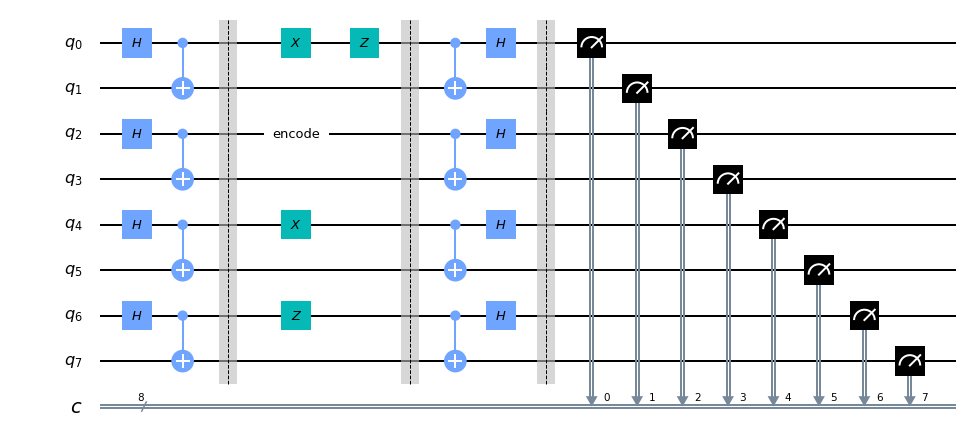

In [29]:
full_c_circuit.decompose().draw('mpl')